In [81]:
#Setup
from qiskit import QuantumCircuit
from dotenv import load_dotenv
import os
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import numpy as np

load_dotenv()
key = os.getenv("IMBQ_KEY")
provider = IBMProvider(token=key)

In [82]:
def select_backend(token, backend='REAL'):
    backend_computer = None
    if backend == 'REAL':
        service = QiskitRuntimeService(channel="ibm_quantum", token=token)
        backend_computer = service.least_busy(simulator=False, operational=True)
    elif backend == 'SIMULATED':
        service = QiskitRuntimeService(channel="ibm_quantum", token=token)
        backend_computer = service.least_busy(simulator=True, operational=True)
    elif backend == 'LOCAL':
        backend_computer = AerSimulator()
    return backend_computer

In [83]:
def optimize_circuit(qc, backend, op_level=0):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=op_level)
    return pm.run(qc)

In [84]:
# def add_range(r1: [], r2: [], out: [], qc: QuantumCircuit):
# 	if qc.num_qubits < len(r1) * 3:
# 		raise ValueError("The circuit must contain at least 3 * len(r1) qubits")
# 	if len(r1) < 2:
# 		raise ValueError("The circuit must contain at least 6 qubits")
# 	if not (len(r1) == len(r2) <= len(out)):
# 		raise ValueError("Lengths of r1 and r2 must be equal")
# 	for i in range(len(r1)):
# 		if r1[i] in r2 or r1[i] in out or r2[i] in out:
# 			raise ValueError("R1, R2 and OUT qubits bust be unique")
# 	for i in range(len(r1)):
# 		qc.cx(r1[i], out[i])
# 		qc.cx(r2[i], out[i])
# 		if i < len(out) - 1:
# 			qc.ccx(r1[i], r2[i], out[i + 1])
def add_range(octet_s: int):
	add_qc = QuantumCircuit(octet_s * 3)
	if octet_s < 2:
		raise ValueError("The circuit must contain at least 6 qubits")
	for i in range(octet_s):
		add_qc.cx(i, i + octet_s * 2)
		add_qc.cx(i +  + octet_s, i + octet_s * 2)
		if i < octet_s - 1:
			add_qc.ccx(i, i +  + octet_s,i + 1 + octet_s * 2)
	return add_qc

                              
q_0: ──■─────────■────────────
       │         │            
q_1: ──┼─────────┼────■───────
       │         │    │       
q_2: ──┼────■────■────┼───────
       │    │    │    │       
q_3: ──┼────┼────┼────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │  
q_4: ┤ X ├┤ X ├──┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐
q_5: ──────────┤ X ├┤ X ├┤ X ├
               └───┘└───┘└───┘


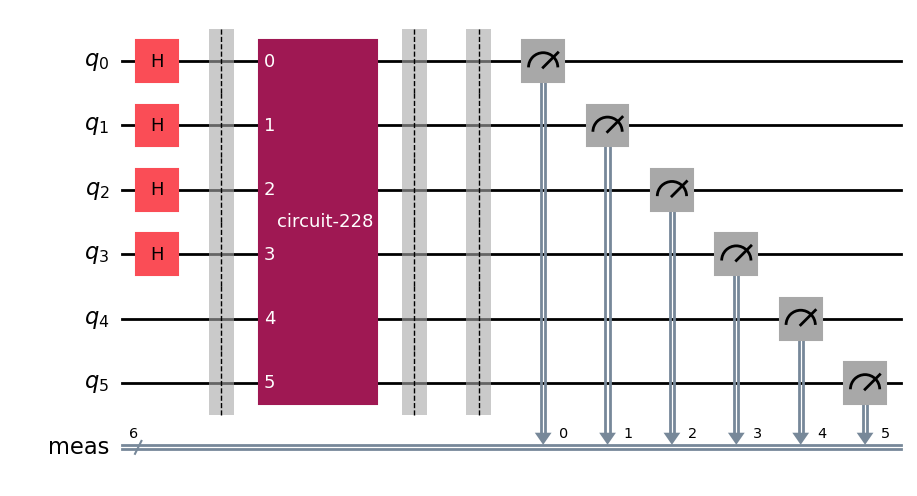

In [85]:
octet_s = 2
qc = QuantumCircuit(octet_s * 3)
r1 = [0, 1]
r2 = [2, 3]
out = [4, 5]
c = [0, 1]

qc.h(r1[0])
qc.h(r1[1])
qc.h(r2[0])
qc.h(r2[1])

qc.barrier()

add_c = add_range(octet_s)
print(add_c.draw())
add_c.to_gate()
qc.append(add_c, range(octet_s * 3))
qc.barrier()

qc.measure_all()


qc.draw('mpl')

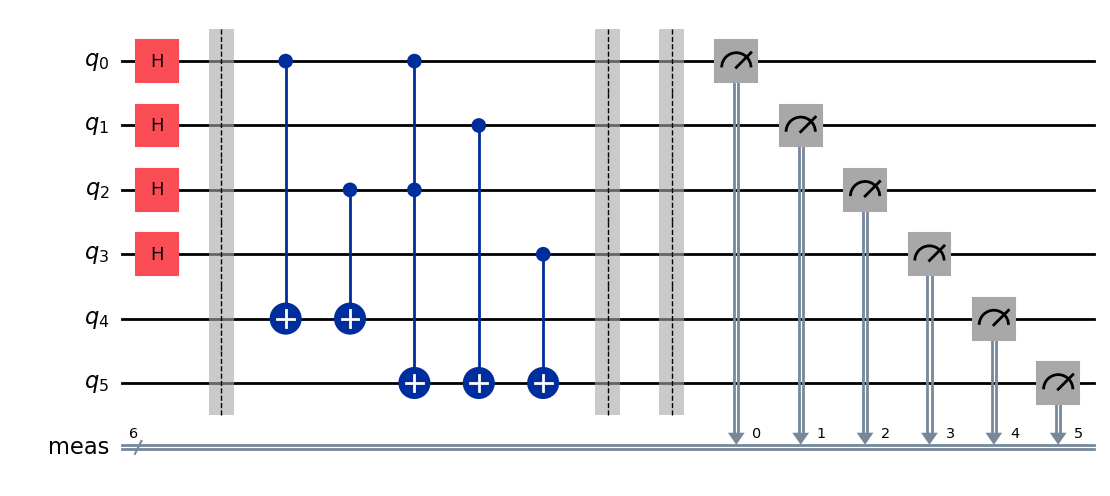

In [86]:
quantum_computer = select_backend(key, backend='SIMULATED')

op_circuit = optimize_circuit(qc=qc, backend=quantum_computer, op_level=0)
op_circuit.draw('mpl', idle_wires=False)

In [87]:
job = quantum_computer.run(op_circuit, shots=500)

In [88]:
job_id = job.job_id()

print("Job ID:", job_id)

result = provider.retrieve_job(job_id).result()
data = result.get_counts(op_circuit)

Job ID: coe3claai5rk2r0krbeg


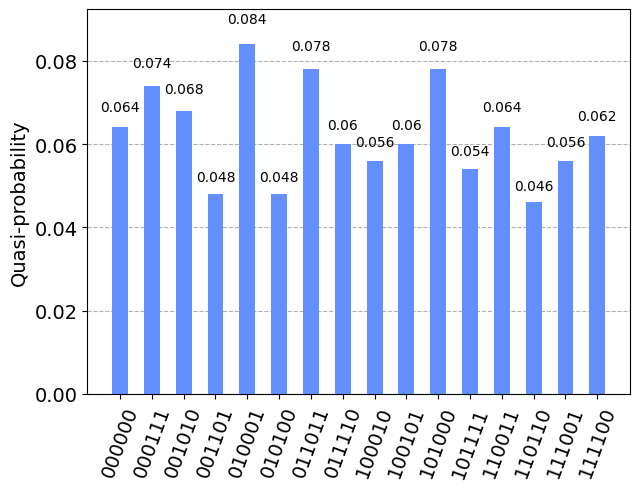

In [89]:
total = sum(data.values())
data = {key: value/total for key, value in data.items()}
plot_histogram([data])